In [130]:
from datascience import *
import numpy as np
import pandas as pd
import matplotlib
from scipy import stats
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from data.city_to_state import city_to_state_dict

I will be using a poster to present a public health/biostatistics informative research on significant connections between air pollution and lung cancer. Inspired by my experiences shadowing cardiac surgeons and recent research regarding how particulate matter induces cancer, I wanted to explore more into the aforementioned study and correlate air quality data. My poster presentation conveys this information in an easy to understand way, mainly focusing on the prevalence and effects of the group 1 carcinogen PM2.5 (particulate matter with a diameter of 2.5 micrometers or less). The poster has dimensions of 22” x 28” and was created in 2022.

Planning:

- Data set on pollution and lung cnacer
- Discuss newer study
- Most carcinogenic particles
- where/how formed
- Impacts on living or decisions


## Introduction

Lung cancer is a disease almost always correlated with smoking, but a rise in never smokers diagnosed with the condition has revealed a factor beyond the control of lifestyle changes: air pollution. More specifically, researchers at the Francis Crick Institute have discovered that PM2.5 (particulate matter at or below a diameter of 2.5 microns) promote the growth of cells containing cancer-causing mutations.

Shadowing a cardiothoracic surgeon the summer of 2022, I similar observations. Many patients who were non-smokers had very dark lungs, some almost indistinguishable from smoker lungs. This led me to a study by Berkley Earth which found that breathing in 22 µg/m3 of PM2.5 pollution is equal to smoking 1 cigarette. The WHO recommends no more than 5 µg/m3, however, no country met that standard. The global population is inadvertently smoking at least 1/4 a cigarette every day, with it being linked strongly to epidermal growth factor receptor (EGFR) mutant lung cancer by the Crick Institute team.

## Objectives

The aim of my study is to:
- Investigate further into possible relations with air pollution and other health factors associated with lung cancer
- Look into factors to correlate with PM2.5 levels.

In [131]:
us_cancer = Table.read_table("./data/USCSOverviewMap.csv").remove(0).drop("Cancer Type", "Type")
us_cancer.show(5)

Area,Year,Sex,Race,Age-Adjusted Rate,Case Count,Population
Puerto Rico,2019,Male and Female,All Races and Ethnicities,15.4,758,3193553
Utah,2019,Male and Female,All Races and Ethnicities,26.4,762,3203383
New Mexico,2019,Male and Female,All Races and Ethnicities,31,886,2099634
California,2019,Male and Female,All Races and Ethnicities,37.1,16860,39437610
Colorado,2019,Male and Female,All Races and Ethnicities,37.7,2471,5758486


In [132]:
air_quality = Table.read_table("./data/air_quality_index.csv").where("COUNTRY", "US").where("DATE", are.below_or_equal_to("2019-12-31"))
air_quality.sort("VALUE", descending=True)

DATE,COUNTRY,CITY,VALUE
2019-03-29,US,The Bronx,153
2019-06-03,US,Denver,147
2019-09-03,US,The Bronx,122
2019-08-28,US,Columbia,117
2019-01-01,US,Fresno,115
2019-04-12,US,Salt Lake City,115
2019-08-07,US,Madison,113
2019-08-27,US,Columbia,102
2019-01-28,US,Fresno,98
2019-01-30,US,Fresno,94


In [133]:
AQ_mean_2019 = air_quality.pivot("COUNTRY", "CITY", "VALUE", np.mean).sort("US", descending=True).relabel("US", "AQI")
AQ_mean_2019
def add_state(city):
    return city_to_state_dict[city]

AQ_mean_2019 = AQ_mean_2019.with_columns(
    "STATE", AQ_mean_2019.apply(add_state, "CITY"),
    "order", np.repeat(1, AQ_mean_2019.num_rows)
)
AQ_state_2019 = AQ_mean_2019.pivot("order", "STATE", "AQI", np.mean).relabel("1", "AQI")
AQ_state_2019

STATE,AQI
Arizona,22.4158
Arkansas,34.2186
California,33.4006
Colorado,30.5241
Connecticut,28.5642
District of Columbia,28.6123
Florida,28.8036
Georgia,37.1658
Hawaii,16.5455
Idaho,27.9677


In [134]:
cancer_states = make_array(2,3,4,5,6,8,9,10,11,12,13,14,17,20,21,22,23,27,29,30,31,32,35,36,37,39,42,43,44,47,29)
cancer_select_states = us_cancer.take(cancer_states)
aq_states = AQ_state_2019.column("STATE")
aq_vs_cancer = cancer_select_states.join("Area", AQ_state_2019, "STATE").relabel("Area", "State").drop("Year", "Sex", "Race")

In [135]:
def str_to_float(string):
    return float(string)

aq_vs_cancer = aq_vs_cancer.with_column("Age-Adjusted Rate", aq_vs_cancer.apply(str_to_float, "Age-Adjusted Rate"))

In [136]:
aq_vs_cancer.show()

State,Age-Adjusted Rate,Case Count,Population,AQI
Arizona,39.2,3905,7291843,22.4158
California,37.1,16860,39437610,33.4006
Colorado,37.7,2471,5758486,30.5241
Florida,52.7,17683,21492056,28.8036
Hawaii,40.4,800,1415615,16.5455
Idaho,44.1,981,1789060,27.9677
Illinois,56.6,9092,12667017,36.1711
Illinois,56.6,9092,12667017,36.1711
Indiana,61.2,5211,6731010,35.0942
Maryland,50.7,3881,6054954,33.6377


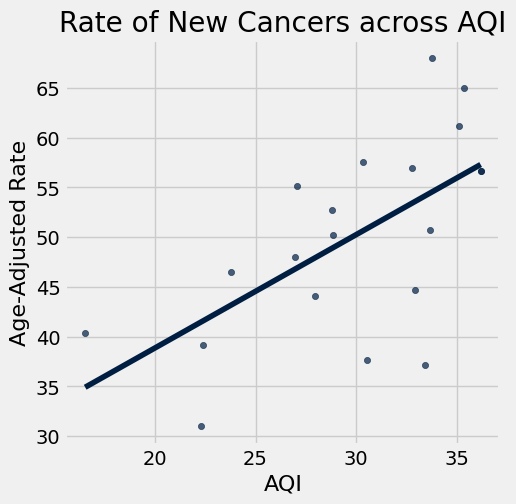

In [137]:
aq_vs_cancer.scatter("AQI", "Age-Adjusted Rate", fit_line=True)
plt.title("Rate of New Cancers across AQI");

In [138]:
aqi = aq_vs_cancer.column("AQI")
rate = aq_vs_cancer.column("Age-Adjusted Rate")
np.corrcoef(aqi, rate).item(1)

0.617035379300217

Better to look at city data as pollution varies across the state. However, was not able to obtain that data.

In [139]:
cancer_factors = Table.read_table("./data/cancer patient data sets.csv").drop("Patient Id").drop("index")
cancer_factors

Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,Smoking,Passive Smoker,Chest Pain,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
33,1,2,4,5,4,3,2,2,4,3,2,2,4,3,4,2,2,3,1,2,3,4,Low
17,1,3,1,5,3,4,2,2,2,2,4,2,3,1,3,7,8,6,2,1,7,2,Medium
35,1,4,5,6,5,5,4,6,7,2,3,4,8,8,7,9,2,1,4,6,7,2,High
37,1,7,7,7,7,6,7,7,7,7,7,7,8,4,2,3,1,4,5,6,7,5,High
46,1,6,8,7,7,7,6,7,7,8,7,7,9,3,2,4,1,4,2,4,2,3,High
35,1,4,5,6,5,5,4,6,7,2,3,4,8,8,7,9,2,1,4,6,7,2,High
52,2,2,4,5,4,3,2,2,4,3,2,2,4,3,4,2,2,3,1,2,3,4,Low
28,2,3,1,4,3,2,3,4,3,1,4,3,1,3,2,2,4,2,2,3,4,3,Low
35,2,4,5,6,5,6,5,5,5,6,6,6,5,1,4,3,2,4,6,2,4,1,Medium
46,1,2,3,4,2,4,3,3,3,2,3,4,4,1,2,4,6,5,4,2,1,5,Medium


In [140]:
pd_cf = cancer_factors.to_df()
pd_cf

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,Low
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,High
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,6,7,7,7,7,6,7,7,...,5,3,2,7,8,2,4,5,3,High
996,37,2,6,8,7,7,7,6,7,7,...,9,6,5,7,2,4,3,1,4,High
997,25,2,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
998,18,2,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High


In [141]:
by_AP = pd_cf.groupby("Air Pollution").mean()
by_AP.drop(["Age", "Gender", "Dust Allergy", "Balanced Diet", "Shortness of Breath", "Clubbing of Finger Nails", "Fatigue", 'Frequent Cold', "Coughing of Blood", "Wheezing", "Chest Pain", "OccuPational Hazards", "Swallowing Difficulty", "Dry Cough", "Snoring"], axis=1)

,Alcohol use,Genetic Risk,chronic Lung Disease,Obesity,Smoking,Passive Smoker,Weight Loss
Air Pollution,,,,,,,
1,3.773050,3.702128,4.141844,3.496454,3.070922,2.638298,2.347518
2,2.557214,3.099502,3.243781,3.353234,3.149254,3.393035,3.800995
3,1.583815,2.589595,2.410405,2.421965,2.514451,2.473988,3.057803
4,4.333333,4.333333,3.777778,5.777778,2.777778,4.000000,5.666667
5,4.000000,4.000000,4.000000,3.500000,5.000000,5.000000,2.000000
6,7.395706,6.730061,6.113497,5.969325,5.322086,5.858896,4.702454
7,7.000000,6.333333,6.666667,7.000000,7.000000,7.000000,3.666667
8,8.000000,7.000000,6.000000,7.000000,8.000000,7.000000,2.000000


<AxesSubplot:xlabel='Air Pollution'>

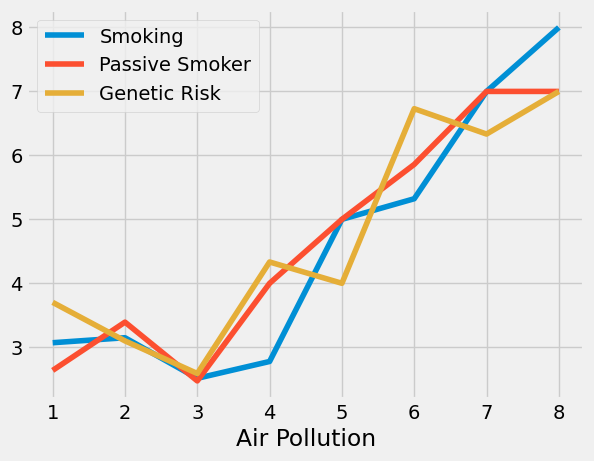

In [142]:
by_AP.plot(y = ["Smoking", "Passive Smoker", "Genetic Risk"])

<Figure size 50000x50000 with 0 Axes>

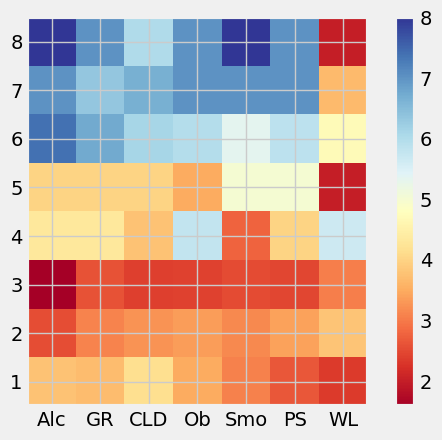

<Figure size 50000x50000 with 0 Axes>

In [145]:
numerical = by_AP.drop(["Age", "Gender", "Dust Allergy", "Balanced Diet", "Shortness of Breath", "Clubbing of Finger Nails", "Fatigue", 'Frequent Cold', "Coughing of Blood", "Wheezing", "Chest Pain", "OccuPational Hazards", "Swallowing Difficulty", "Dry Cough", "Snoring"], axis=1).rename(columns={"chronic Lung Disease": "CLD", "Balanced Diet" : "Diet", "Weight Loss": "WL", "Genetic Risk" : "GR", "Alcohol use" : "Alc", "Passive Smoker" : "PS", "Obesity" : "Ob", "Smoking" : "Smo"}).sort_values(by ="Air Pollution", ascending = False)
plt.imshow(numerical, cmap ="RdYlBu")
plt.colorbar()
plt.xticks(ticks=np.arange(len(numerical.columns)), labels=numerical.columns);
plt.yticks(np.arange(len(numerical)), numerical.index);
plt.figure(figsize=(500,500))

In [146]:
{"chronic Lung Disease": "CLD", "Balanced Diet" : "Diet", "Weight Loss": "WL", "Genetic Risk" : "GR", "Alcohol use" : "Alc", "Passive Smoker" : "PS", "Obesity" : "Ob", "Smoking" : "Smo"}

{'chronic Lung Disease': 'CLD',
 'Balanced Diet': 'Diet',
 'Weight Loss': 'WL',
 'Genetic Risk': 'GR',
 'Alcohol use': 'Alc',
 'Passive Smoker': 'PS',
 'Obesity': 'Ob',
 'Smoking': 'Smo'}